**Approach 1:** 


*   Using finetuning of pretrained model, VGG16, VGG19, DenseNet on MICC dataset.
*   Using pretrained model, VGG16, VGG19, DenseNet to extract features on MICC dataset.




In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CVDatasets


In [3]:

import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv

dataset = 'MICC'
# dataset = 'CASIA'


##loading images and adding labels into csv
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if "tamp" in filename: ##1 is tampered
          images.append([filename,1])
        else:
          images.append([filename,0])  
    return images



fields = ['name','score']
if dataset == 'MICC':
  images = load_images_from_folder('MICC-F2000')

  with open('MICC-F2000-images-labels.csv', 'w') as f:
      write = csv.writer(f)
      write.writerow(fields)
      write.writerows(images)




**Loading Data**

In [30]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torchvision import transforms

batch_size = 16

class TamperDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_list = pd.read_csv(csv_file,header=1)
        self.root_dir = root_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                self.images_list.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.images_list.iloc[idx, 1]
        if self.transform:
          image = self.transform(image)
        return image,int(label)



**Applying Transformations **

In [31]:

input_size =224
batch_size = 16

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


tamper_dataset = TamperDataset(csv_file='MICC-F2000-images-labels.csv',
                                    root_dir='MICC-F2000',transform=data_transforms['train'])

tamper_dataset_val = TamperDataset(csv_file='MICC-F220-images-labels.csv',
                                    root_dir='MICC-F220',transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(
    tamper_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

validation_loader = torch.utils.data.DataLoader(
    tamper_dataset_val, batch_size=batch_size, shuffle=True, num_workers=1)



In [34]:
dataloaders_dict = {"train": train_loader,'val': validation_loader}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224]) tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1])


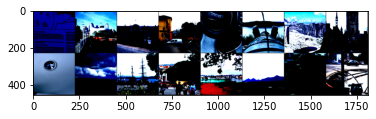

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape,labels)
# show images
imshow(torchvision.utils.make_grid(torch.tensor(images)))

**Pre Trained Model Setup for Finetuning**

In [46]:
##model 1 -> Pre trained

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


num_classes = 2
num_epochs = 4


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

**Choosing type of Model**

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


model_name = "vgg"

feature_extract = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

**Visualising layers**

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

DROP_LAYERS = False

if DROP_LAYERS:
  feats_list = list(model_ft.features)
  new_feats_list = []
  for feat in feats_list:
      new_feats_list.append(feat)
      if isinstance(feat, nn.Conv2d):
          new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

  # modify convolution layers
  model_ft.features = nn.Sequential(*new_feats_list)
  print("Params updated:")

  for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)



Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [1]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 

# Initialize the model
model_vgg = models.vgg19(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
new_model = FeatureExtractor(model_vgg)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

phase = 'train'

feature_list = []

for inputs, labels in dataloaders_dict[phase]:
    for img in inputs:
      feature = new_model(img)
      feature.append()
      feature_list.append(feature.cpu().detach().numpy().reshape(-1))


**Training Model**

In [50]:
# import time
import os
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,verbose=True)
num_epochs=30
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [52]:
model_file = 'model_vgg_feat' + str(num_epochs) + '.pth'
torch.save(model_ft.state_dict(), model_file)
print('\nSaved model to ' + model_file + '.')


Saved model to model_vgg_feat30.pth.


**Display images in dataset**


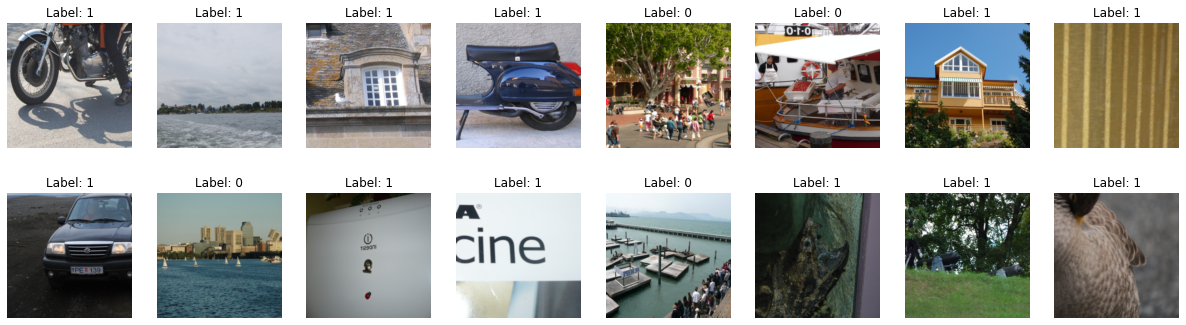

In [42]:
def showimages(imgs,actual_lbls,pred_lbls=None):
   
  fig = plt.figure(figsize=(21,12))
 
  for i,img in enumerate(imgs):
     
    fig.add_subplot(4,8, i+1)
    y=actual_lbls[i]
     
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(y,y_pre)
    else: 
      title="Label: {0}".format(y)
 
    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
   
plt.show()
 
inputs, classes = next(iter(train_loader))
 
showimages(inputs,classes)

**Predicting results and showing.**

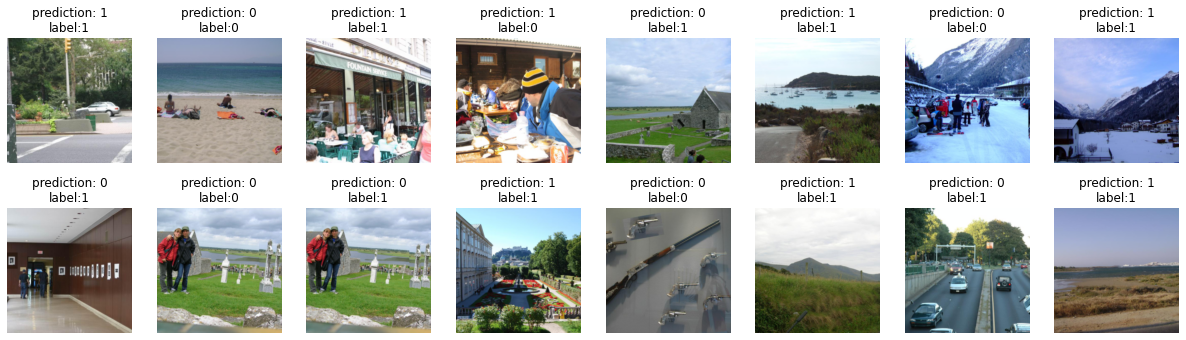

In [61]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images,actual_label,preds.cpu())
 
images, classes = next(iter(validation_loader))
 
predict_images(model_ft,images,classes)


**Approach 2:**
Using CNN and SVM with patch features, Explained in detail in the report.

In [2]:
%cd
%rm -rf Deep-Learning-Based-Tamper-Detection-on-Images
!git clone https://github.com/ruparelmetarya/Deep-Learning-Based-Tamper-Detection-on-Images.git
%cd Deep-Learning-Based-Tamper-Detection-on-Images

/root
Cloning into 'Deep-Learning-Based-Tamper-Detection-on-Images'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 103 (delta 27), reused 100 (delta 27), pack-reused 0
Receiving objects: 100% (103/103), 45.57 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/root/Deep-Learning-Based-Tamper-Detection-on-Images


In [ ]:
!pip install -r requirements.txt

Extracting masks(ground truth) from Tampered images using authentic. 

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import csv
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity

%cd 
%cd /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/

##Extracts and saves the mask (ground truth) for the given tampered image.
def find_mask(sp_pic, au_pic_dict):
    background_index = [13, 21] 
    save_name = sp_pic.split("/")[-1][:-4]  # name of the mask
    sp_name = sp_pic.split("/")[-1][background_index[0]:background_index[1]]
    if sp_name in au_pic_dict.keys():
        au_pic = au_pic_dict[sp_name]
        au_image = plt.imread(au_pic)
        sp_image = plt.imread(sp_pic)
        if sp_image.shape == au_image.shape:
            # convert images to grayscale
            gray_au_image = cv2.cvtColor(au_image, cv2.COLOR_BGR2GRAY)
            gray_sp_image = cv2.cvtColor(sp_image, cv2.COLOR_BGR2GRAY)
            # get the difference of the 2 grayscale images
            (_, diff) = structural_similarity(gray_au_image, gray_sp_image, full=True)
            diff = cv2.medianBlur(diff, 1)
            # make background black and tampered area white
            mask = np.ones_like(diff)
            mask[diff < 0.98] = 1
            mask[diff >= 0.98] = 0
            mask = (mask * 255).astype("uint8")
            cv2.imwrite('CASIA2/masks/' + save_name + '_gt.png', mask)


def extract_masks():
    """
    Extracts and saves all the masks.
    """
    # create the save directory
    save_dir = 'CASIA2/masks/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    else:
        return

    # read the authentic and tampered images
    au_pic_list = glob('CASIA2/Au/*')
    sp_pic_list = glob('CASIA2/Tp/*')


    au_index = [3, 6, 7, 12]  # indices of authetic image name

    au_pic_dict = {au_pic.split("/")[-1][au_index[0]:au_index[1]] + au_pic.split("/")[-1][au_index[2]:au_index[3]]:au_pic for au_pic in au_pic_list}
    # extract the mask for every tampered image
    for _, Sp_pic in enumerate(sp_pic_list):
        find_mask(Sp_pic, au_pic_dict)

extract_masks()



**Extract patches. rot: for rotation, no_rot: normal **

In [14]:
from patch_extraction.patch_extractor_casia import PatchExtractorCASIA
%cd 
%cd /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/

patchs = PatchExtractorCASIA(input_path='CASIA2', output_path='CASIA2/patches/',patches_per_image=2, stride=128, rotations=4, mode='no_rot')
patchs.extract_patches()

In [15]:
##training
import torch
import pandas as pd
import torchvision.transforms as transforms
from torchvision import datasets
from cnn.cnn import CNN
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import time
import numpy as np

%cd 
%cd /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/

train_set = datasets.ImageFolder(root="CASIA2/patches/", transform=transforms.Compose([transforms.ToTensor()]))  # Fetch data

if str(device) == "cuda:0":
    net = CNN().cuda()
else:
    net = CNN()


In [66]:
n_epochs = 1
batch_size = 128
learning_rate = 0.0001

**Training the CNN**

In [67]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.99, weight_decay=5 * 1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
n_batches = len(train_loader)
epoch_loss = []
epoch_accuracy = []

for epoch in range(n_epochs):

    total_running_loss = 0.0
    print_every = n_batches // 5
    training_start_time = time.time()
    c = 0
    total_predicted = []
    total_labels = []

    for i, (inputs, labels) in enumerate(train_loader):
        # get the inputs
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda().long())
        else:
            inputs = Variable(inputs)
            labels = Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total_labels.extend(labels)
        total_predicted.extend(predicted)

        if (i + 1) % (print_every + 1) == 0:
            total_running_loss += loss.item()
            c += 1

    epoch_predictions = (np.array(total_predicted) == np.array(total_labels)).sum().item()
    print('######### Epoch %d Loss: %.3f Accuracy: %.3f Time: %.3f #########' % (epoch + 1, total_running_loss / c, epoch_predictions / len(total_predicted),
        time.time() - training_start_time))
    epoch_accuracy.append(epoch_predictions / len(total_predicted))
    epoch_loss.append(total_running_loss / c)
    scheduler.step()


print(epoch_loss, epoch_accuracy)


######### Epoch 1 Loss: 0.693 Accuracy: 0.500 Time: 320.209 #########
[0.6927139163017273] [0.5]


In [ ]:
# # torch.save(cnn.state_dict(), 'CASIA2_m2_b128.pt')


**Get feature vectors of images**

In [16]:
###get features and store
import torch
from cnn.cnn import CNN
from feature_fusion.feature_vector_generation import create_feature_vectors
import pandas as pd
from classification.SVM import optimize_hyperparams, classify, print_confusion_matrix, find_misclassified
%cd 
%cd /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/


with torch.no_grad():
    model = CNN()
    model.load_state_dict(torch.load('/root/Deep-Learning-Based-Tamper-Detection-on-Images/models/CASIA2_m2_b128.pt',map_location=lambda storage, loc: storage))
    model.eval()
    model = model.double()

    authentic_path = 'CASIA2/Au/*'
    tampered_path = 'CASIA2/Tp/*'
    output_filename = 'CASIA2/CASIA2_m2_b128_feat.csv'
    df = create_feature_vectors(model, 'CASIA2/Tp/*', 'CASIA2/Au/*', output_filename)


**Classify and metrics with SVM**

Optimal hyper-parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy : 0.9682104610960787
[0.95166403 0.96830428 0.9889065  0.95721078 0.96590008 0.98017446
 0.96272799 0.95241872 0.97462331 0.98017446]
0.9682104610960787
0.011980343617648959
True negatives:  1426 False positives:  72 False negatives:  17 True positives:  1008


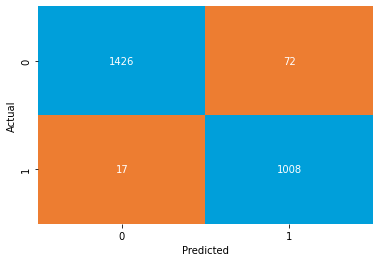

In [5]:
import pandas as pd
from classification.SVM import optimize_hyperparams, classify, print_confusion_matrix, find_misclassified

df = pd.read_csv('/root/Deep-Learning-Based-Tamper-Detection-on-Images/models/CASIA2_m2_b128_feat.csv')

X = df.loc[:, ~df.columns.isin(['labels', 'image_names'])]
y = df['labels']

img_ids = df['image_names']


hyper_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

opt_params = optimize_hyperparams(X, y, params=hyper_params)


classify(X, y, opt_params)
print_confusion_matrix(X, y, opt_params)
find_misclassified(X, y, opt_params, img_ids)


In [ ]:
##validating on CASIA
from joblib import load
import torch
from cnn.cnn import CNN
from cv2 import imread
import numpy as np
from sklearn.metrics import confusion_matrix
import random
from sklearn.metrics import accuracy_score

import pandas as pd
from feature_fusion.feature_vector_generation import get_patch_yi
from classification.SVM import optimize_hyperparams, classify, print_confusion_matrix, find_misclassified


def get_feature_vector(image_path: str, model):
    feature_vector = np.empty((1, 400))
    feature_vector[0, :] = get_patch_yi(model, imread(image_path))
    return feature_vector


def predict_images(model,svm_mod,images,actual_labels):
  model.eval()
  with torch.no_grad():
    preds = []
    feature_list = []
    for image in images:
      feature_vector = get_feature_vector(image, model)
      feature_list.append(feature_vector)
      out = svm_model.predict(feature_vector)
      preds.append(out)

    X = feature_list
    y_test = list(actual_labels)
    y_pred = preds
    acc = accuracy_score(y_test, y_pred)
    print('Acc: ',acc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('True negatives: ', tn, 'False positives: ', fp, 'False negatives: ', fn, 'True positives: ', tp)
    # Using seaborn to create a confusion matrix table
    data = {'y_Predicted': y_pred, 'y_Actual': y_test}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    misclassified = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            misclassified.append([y_pred[i],y_test[i]])
    return acc, y_pred, len(misclassified)


# Load the pretrained CNN with the CASIA2 dataset
with torch.no_grad():
    our_cnn = CNN()
    our_cnn.load_state_dict(torch.load('/root/Deep-Learning-Based-Tamper-Detection-on-Images/models/CASIA2_m1_b200.pt',map_location=lambda storage, loc: storage))
    our_cnn.eval()
    our_cnn = our_cnn.double()

# Load the pretrained svm model
svm_model = load('/root/Deep-Learning-Based-Tamper-Detection-on-Images/models/CASIA2_svm_b128.pt')
print("Labels: 0 -> non-tampered, 1 -> tampered")



**Validating authentic images 20% data**

In [ ]:
%cd 
%cd /content/drive/'My Drive'/'Colab Notebooks'/CVDatasets/

csv_file = 'au_list.txt'

images_df = pd.read_csv(csv_file,header=1)
classes = np.zeros(images_df.shape[0])
images_list = list(images_df.iloc[:,0])
au_count = images_df.shape[0]
val_size_au = int(au_count*0.2) 
%cd Au
acc1,_,miss1 = predict_images(our_cnn,svm_model,random.sample(images_list,val_size_au),classes[:val_size_au])
print(acc1,miss1)


**Validating tempered images**

In [ ]:
%cd ..
csv_file1 = 'tp_list.txt'
images_df1 = pd.read_csv(csv_file1,header=1)
classes_tp = np.ones(images_df1.shape[0])
images_list_tp = list(images_df1.iloc[:,0])
tp_count = images_df1.shape[0]
val_size_tp = int(tp_count*0.2)
%cd Tp
acc2,_,miss2 = predict_images(our_cnn,svm_model,np.array(random.sample(images_list_tp, val_size_tp)),classes_tp[:val_size_tp])
print(acc2,miss2)

In [ ]:
totalacc = ((val_size_tp+val_size_au) - (miss1 + miss2))/((val_size_tp+val_size_au))
print("Total Acc validation for  ",val_size_tp+val_size_au," images: " ,totalacc)

**Graph and results present in report.**